In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from torchmetrics.classification import MulticlassConfusionMatrix

In [2]:
# Hyperparameters
batch_size = 32
epochs = 50
lr = 2e-3
transform = transforms.ToTensor()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
trainset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size, shuffle=False)

In [4]:
image, label = trainset[0]
image.shape

torch.Size([1, 28, 28])

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25),

            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=1024),
            nn.LeakyReLU(0.02),
            nn.BatchNorm1d(num_features=1024),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(0.02),
            nn.BatchNorm1d(num_features=512),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=10),
            #nn.Softmax()
        )

    def forward(self, x):
        return self.convlayer(x)

In [6]:
training_writer = SummaryWriter(log_dir="runs/DeepCNN")

In [7]:
# Training

model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
step = 0
best_val_loss = float('inf')
for epoch in range(epochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        model.train()
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_accuracy = 100 * (correct_train / total_train)

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    model.eval()
    with torch.no_grad():
        for batch, (test_images, test_labels) in enumerate(testloader):
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            output = model(test_images)
            loss = criterion(output, test_labels)
            val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total_val += test_labels.size(0)
            correct_val += (predicted == test_labels).sum().item()
    
    val_loss = val_loss / len(testloader)
    val_accuracy = 100 * (correct_val / total_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_DeepCNN.pth")
    
    # Log to tensorboard
    training_writer.add_scalar("Train loss", train_loss, step)
    training_writer.add_scalar("Train accuracy", train_accuracy, step)
    training_writer.add_scalar("Validation loss", val_loss, step)
    training_writer.add_scalar("Validation accuracy", val_accuracy, step)
    step += 1

    print(f'Epoch: {epoch+1} / {epochs}  | Training loss: {train_loss:.4f} | Train accuracy: {train_accuracy:.4f} | Validation loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}')

Epoch: 1 / 50  | Training loss: 0.2133 | Train accuracy: 93.3450 | Validation loss: 0.0509 | Validation Accuracy: 98.3100
Epoch: 2 / 50  | Training loss: 0.1181 | Train accuracy: 96.4683 | Validation loss: 0.0359 | Validation Accuracy: 98.7800
Epoch: 3 / 50  | Training loss: 0.0964 | Train accuracy: 97.0550 | Validation loss: 0.0418 | Validation Accuracy: 98.3900
Epoch: 4 / 50  | Training loss: 0.0835 | Train accuracy: 97.4517 | Validation loss: 0.0305 | Validation Accuracy: 98.9100
Epoch: 5 / 50  | Training loss: 0.0724 | Train accuracy: 97.8000 | Validation loss: 0.0303 | Validation Accuracy: 99.0600
Epoch: 6 / 50  | Training loss: 0.0624 | Train accuracy: 98.1250 | Validation loss: 0.0264 | Validation Accuracy: 99.1500
Epoch: 7 / 50  | Training loss: 0.0607 | Train accuracy: 98.1883 | Validation loss: 0.0232 | Validation Accuracy: 99.2900
Epoch: 8 / 50  | Training loss: 0.0558 | Train accuracy: 98.2900 | Validation loss: 0.0214 | Validation Accuracy: 99.2900
Epoch: 9 / 50  | Trainin

In [8]:
model1 = ConvNet()
model1.load_state_dict(torch.load("best_DeepCNN.pth"))

<All keys matched successfully>

In [144]:
model1.eval()
confusionmatrix = MulticlassConfusionMatrix(num_classes=10)
with torch.no_grad():
    for batch, (images, labels) in enumerate(testloader):
        images, labels = images, labels
        outputs = model1(images)
        _, preds = torch.max(outputs, 1)
        confusionmatrix.update(preds, labels)

cm = confusionmatrix.compute()

In [145]:
confusionmatrix.plot()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

In [12]:
model1.eval()
images_of_fours = []

for image, label in trainset:
    if label == 4 and len(images_of_fours) < 9:
        images_of_fours.append(image)
    if len(images_of_fours) == 9:
        break

images_of_fours = torch.stack(images_of_fours)


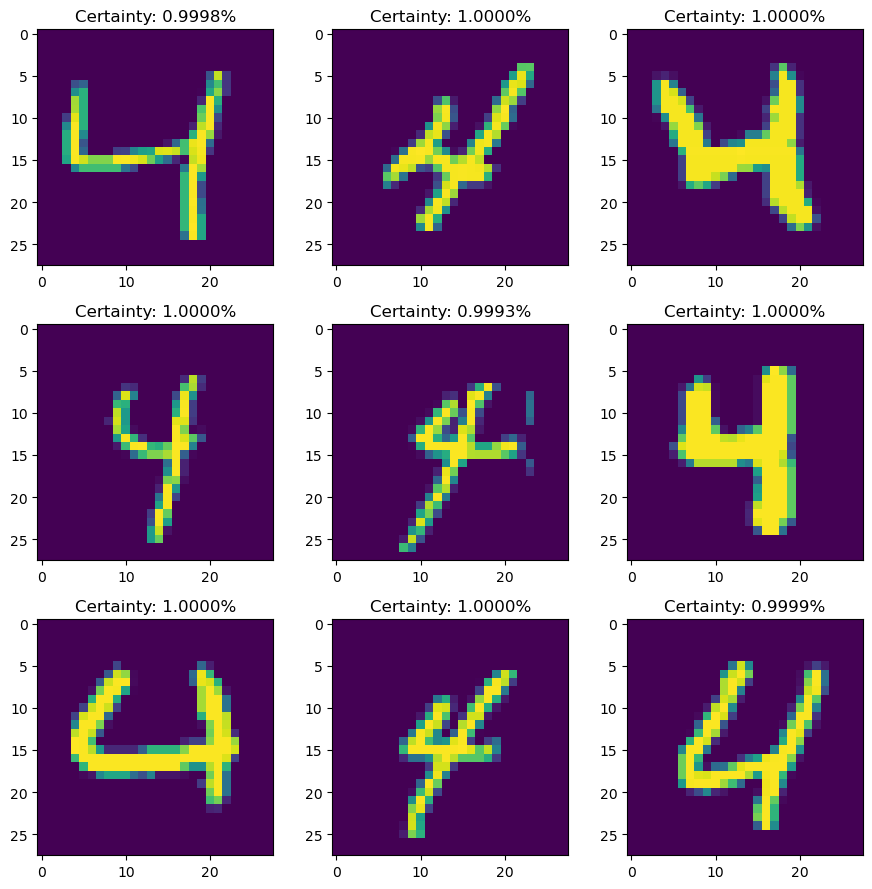

In [42]:
model1.eval()
images_of_fours = []
# Getting some fours
for image, label in trainset:
    if label == 4 and len(images_of_fours) < 9:
        images_of_fours.append(image)
    if len(images_of_fours) == 9:
        break
images_of_fours = torch.stack(images_of_fours)

# Running the model to get some probabilities
with torch.no_grad():
    outputs = model1(images_of_fours)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    index = 4
    certainties = probabilities[:, index]

# Doing the plot
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
images_of_fours = images_of_fours.squeeze(1)
for i, ax in enumerate(axes.flatten()):
    img = images_of_fours[i].numpy()
    uncertainty = certainties[i].item()
    ax.imshow(img)
    ax.set_title(f"Certainty: {uncertainty:.4f}%")

plt.tight_layout()
plt.show()

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def create_plot_adversarial_images(model, image, old_label, new_label, n_steps, lr=0.1):
    original_image = image.clone().detach()
    image = image.clone().detach().requires_grad_(True)
    new_label_tensor = torch.tensor([new_label])

    loss_fn = nn.CrossEntropyLoss()
    probs_old_label = []
    probs_new_label = []
    adversarial_image_steps = []
    delta_image_steps = []

    for step in range(n_steps):
        outputs = model(image)
        loss = loss_fn(outputs, new_label_tensor)
        model.zero_grad()
        loss.backward()
        image_adv = image - lr * image.grad.sign() / n_steps
        image_adv = torch.clamp(image_adv, 0, 1)
        
        delta_image = image_adv - original_image

        with torch.no_grad():
            output_adv = model(image_adv)
            probs = F.softmax(output_adv, dim=1) * 100

        probs_old_label.append(probs[0][old_label].item())
        probs_new_label.append(probs[0][new_label].item())
        adversarial_image_steps.append(image_adv.clone().detach())
        delta_image_steps.append(delta_image.clone().detach())

        image.data = image_adv.data

    return_dict = {
        'original_image': original_image,
        'delta_image': delta_image_steps,
        'adversarial_image': adversarial_image_steps,
        'probs_old_label': probs_old_label,
        'probs_new_label': probs_new_label
    }
    
    return return_dict


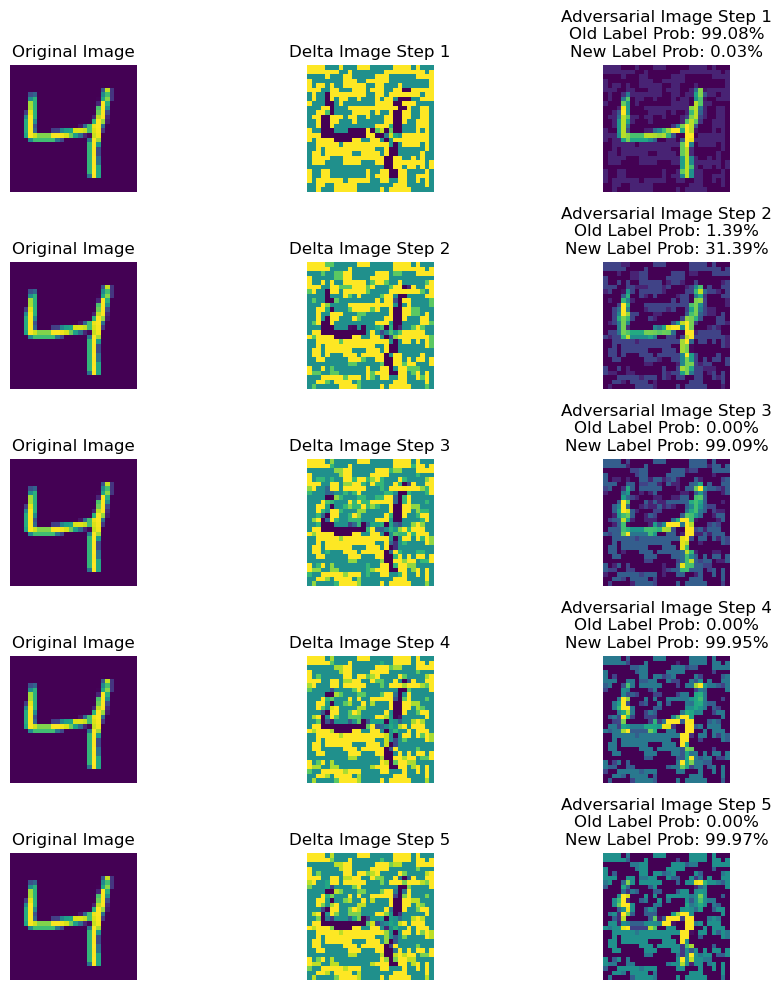

In [139]:
def plot_adversarial_steps(return_dict):
    num_steps = len(return_dict['adversarial_image'])
    fig, axs = plt.subplots(num_steps, 3, figsize=(10, num_steps * 2))

    for i in range(num_steps):
        axs[i, 0].imshow(return_dict['original_image'].squeeze())
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(return_dict['delta_image'][i].squeeze())
        axs[i, 1].set_title(f'Delta Image Step {i+1}')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(return_dict['adversarial_image'][i].squeeze())
        axs[i, 2].set_title(f'Adversarial Image Step {i+1}\nOld Label Prob: {return_dict["probs_old_label"][i]:.2f}%\nNew Label Prob: {return_dict["probs_new_label"][i]:.2f}%')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

result = create_plot_adversarial_images(model1, image=images_of_fours[0].unsqueeze(0).unsqueeze(0), old_label=4, new_label=6, n_steps=5, lr=0.5)
plot_adversarial_steps(result)



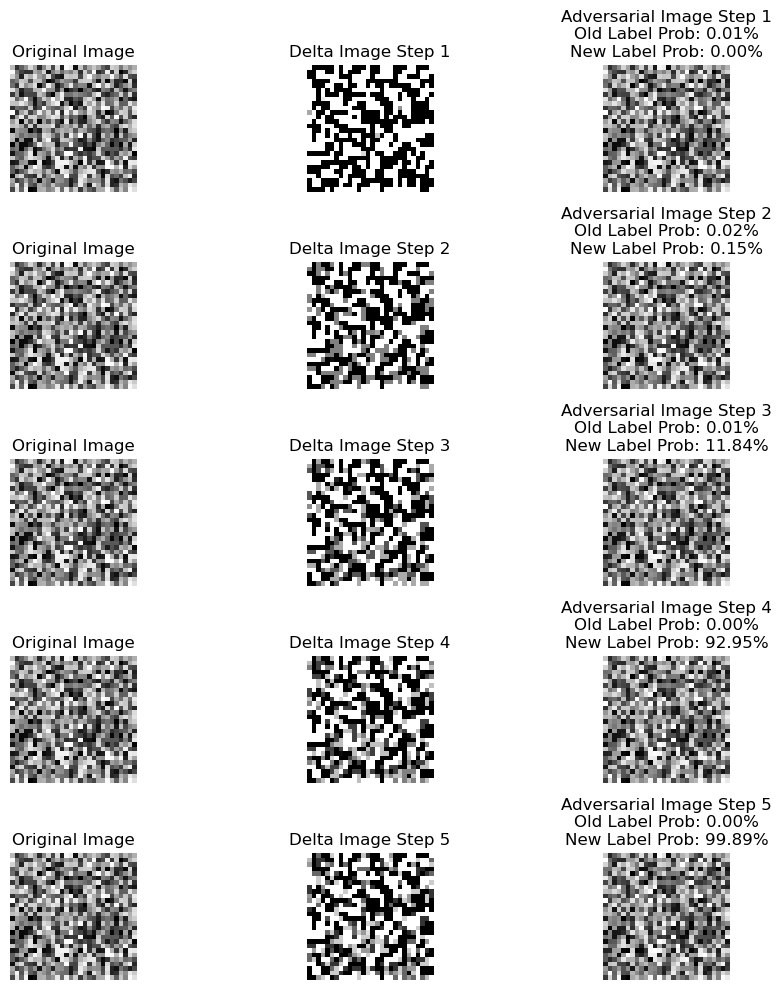

In [137]:
noise = torch.rand(1, 1, 28, 28)
result = create_plot_adversarial_images(model1, image=noise, old_label=1, new_label=6, n_steps=5, lr=0.05)
plot_adversarial_steps(result)